In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from ranger import Ranger
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

%matplotlib inline


seed = 12345

In [2]:
PATH = os.path.abspath('../../alfalfa-convnets')

sys.path.append(f'{PATH}/src')

from mxresnet import *


Mish activation loaded...
Mish activation loaded...


# Grab data, trained model

In [3]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
df.sample(2)

,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,...,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB
1051,25721,252708,J155506.74+093023.0,1726,53137,603,238.77810,9.50642,0.034070,149.7,...,-1.229,0.0,0.655,452932,2373135,1,1,0,0.0,-99.0
1097,122006,320897,J225258.55+010833.3,379,51789,449,343.24399,1.14259,0.016449,71.3,...,0.160,1.0,2.343,-99,-99,-1,0,0,0.0,-99.0


In [4]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

bs = 32
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['lgGF'])
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(image_stats)
       )

In [5]:
model = mxresnet34()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True) #.cuda()


In [6]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [7]:
learn.load('best_xgass-34');

set state called


In [8]:
m = learn.model.eval();

## Check some images

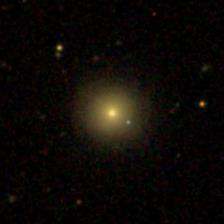

[-1.637442]


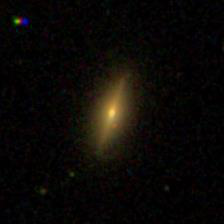

[-1.798421]


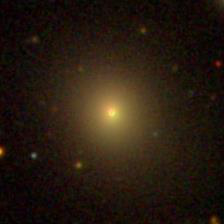

[-1.913978]


In [20]:
for fn in np.random.choice(data.valid_dl.items, size=3, replace=False):
    img = open_image(fn);
    
    display(img)
    print(learn.predict(img)[0])

In [35]:
model[7][2]

ResBlock(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

# Hook outputs of final conv layer

In [40]:
m = learn.model.eval();

target_layer = m[7][-1].convs[-1]

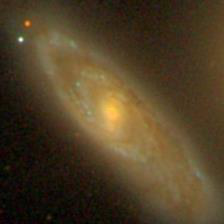

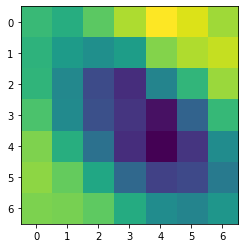

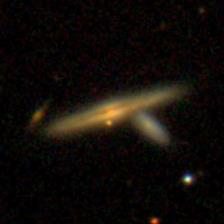

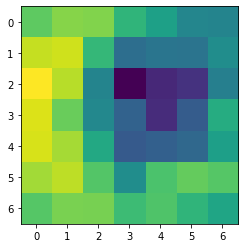

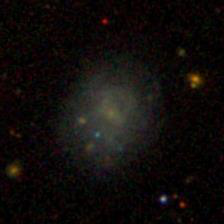

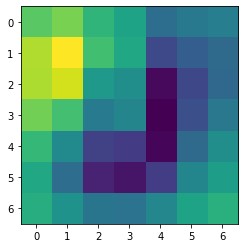

In [52]:
for fn in np.random.choice(data.valid_dl.items, size=3, replace=False):
    img = open_image(fn);
    
    
    # get single item
    X, _ = learn.data.one_item(img)
    
    # get activations after final conv layers
    with hook_output(target_layer) as hook_a:
        pred = m(X.cuda())
        acts = hook_a.stored[0].cpu().numpy()
    
    # plot img and acts
    display(img)
    plt.imshow(acts.mean(0))
    plt.show()

# Hook penultimate layer 

Shape should be (512,)

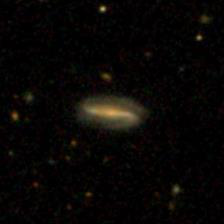

[ 0.054866  0.00316   0.00605   0.006931 ...  0.044848  0.000798  0.019087 -0.022967]


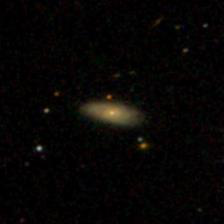

[ 0.081328  0.013217 -0.006475  0.007251 ...  0.05961   0.028861  0.003545 -0.029272]


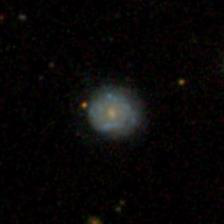

[-0.081826  0.011578 -0.059913 -0.003622 ... -0.019056 -0.017996  0.013692  0.04117 ]


In [65]:
for fn in np.random.choice(data.valid_dl.items, size=3, replace=False):
    img = open_image(fn);
        
    # get single item
    X, _ = learn.data.one_item(img)
    
    # get activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
        acts = hook_a.stored[0].cpu().numpy()
    
    # plot img and acts
    display(img)
    print(acts)

# Get valid set and PCA those babies

In [9]:
N_valid = len(data.valid_ds)
N_valid

235

In [10]:
valid_acts = np.zeros(shape=(N_valid, 512))

# grab all activations for validation set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_valid):
    img = open_image(fn);
        
    # get single item
    X, _ = learn.data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        valid_acts[i] = hook_a.stored[0].cpu().numpy()

In [11]:
valid_acts_PCA = PCA(n_components=3).fit_transform(valid_acts)

In [12]:
valid_acts_PCA.shape

(235, 3)

In [15]:
# np.save(f'../results/valid_acts_PCA.npy', valid_acts_PCA)
valid_acts_PCA = np.load(f'../results/valid_acts_PCA.npy')

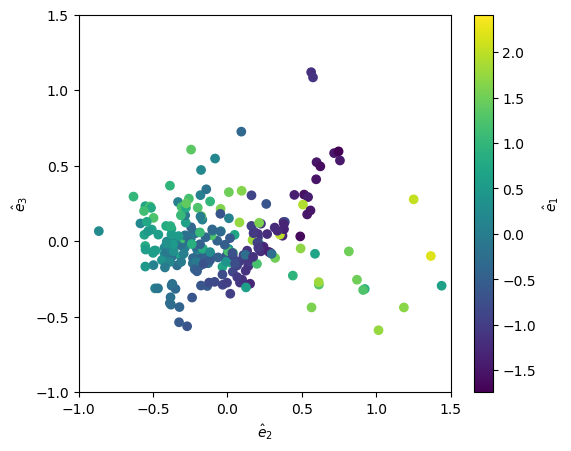

In [34]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_PCA[:, 1], valid_acts_PCA[:, 2], c=valid_acts_PCA[:, 0])

cb = plt.colorbar()
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

cb.set_label(r'$\hat e_1$')
plt.xlabel(r'$\hat e_2$')
plt.ylabel(r'$\hat e_3$');

## Color these by true gas fraction

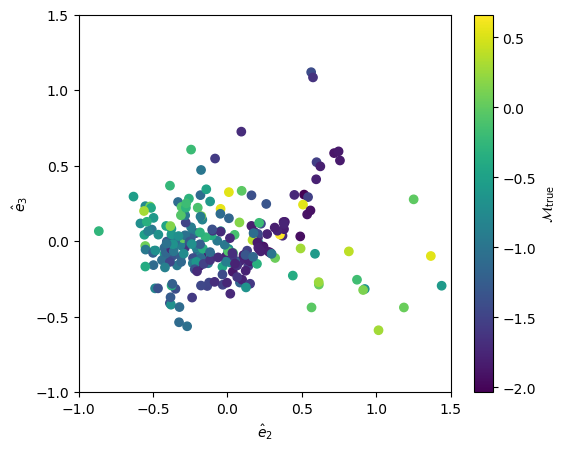

In [35]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_PCA[:, 1], valid_acts_PCA[:, 2], c=data.valid_ds.y.items)

plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

cb = plt.colorbar()
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'$\hat e_2$')
plt.ylabel(r'$\hat e_3$');

Fascinating, basically the first eigenvector is just the gas fraction vector. Makes sense since that should explain all the variance, and we're fully linear in the final layer.

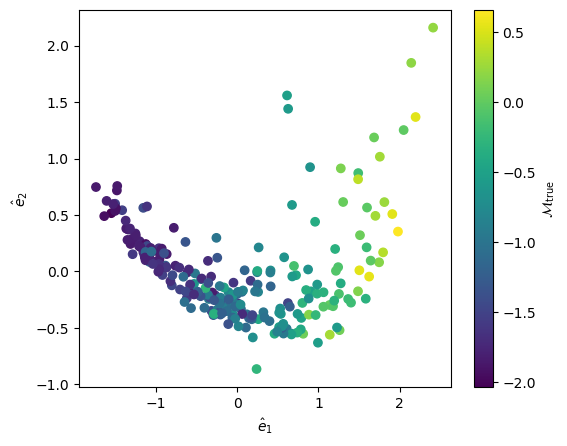

In [36]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=data.valid_ds.y.items)

cb = plt.colorbar()
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'$\hat e_1$')
plt.ylabel(r'$\hat e_2$');

Yep, this confirms it. The "x"-axis is nearly identical to the colorbar (true metallicity) and probably even more similar to the predicted metallicity."

So then... does that mean that e_2 and e_3 are closer to morphological variance? (or higher eigenvectors)

## More experiments

In [37]:
valid_acts_PCA = PCA(n_components=10).fit_transform(valid_acts)

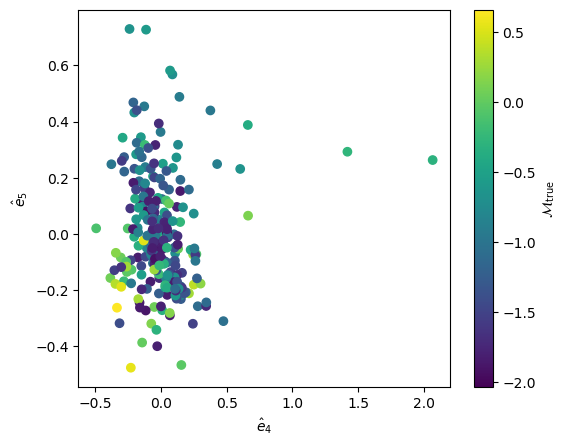

In [38]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(valid_acts_PCA[:, 3], valid_acts_PCA[:, 4], c=data.valid_ds.y.items)

cb = plt.colorbar()
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'$\hat e_4$')
plt.ylabel(r'$\hat e_5$');

# Get training data

In [40]:
N_train = len(data.train_ds.items)
N_train

944

In [41]:
train_acts = np.zeros(shape=(N_train, 512))

# grab all activations for validation set
for i, fn in tqdm(enumerate(data.train_ds.items), total=N_train):
    img = open_image(fn);
        
    # get single item
    X, _ = learn.data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        train_acts[i] = hook_a.stored[0].cpu().numpy()

In [42]:
train_acts_PCA = PCA(n_components=6).fit_transform(train_acts)

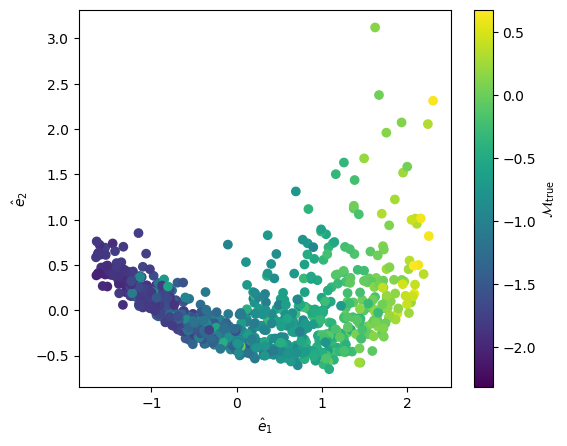

In [43]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c=data.train_ds.y.items)

cb = plt.colorbar()
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'$\hat e_1$')
plt.ylabel(r'$\hat e_2$');

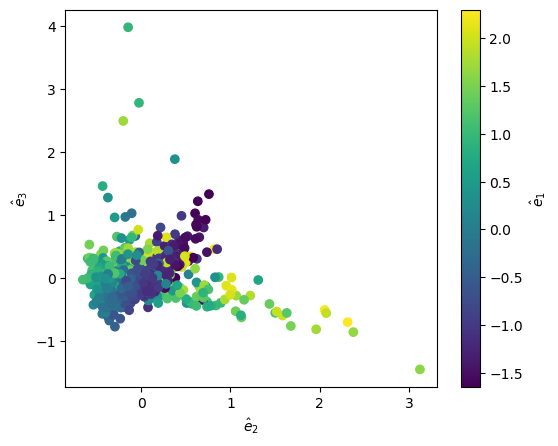

In [18]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 1], train_acts_PCA[:, 2], c=train_acts_PCA[:, 0])

cb = plt.colorbar()
cb.set_label(r'$\hat e_1$')
plt.xlabel(r'$\hat e_2$')
plt.ylabel(r'$\hat e_3$');

In [16]:
# np.save(f'../results/train_acts_PCA.npy', train_acts_PCA)
train_acts_PCA = np.load(f'../results/train_acts_PCA.npy')

# TODO

* Find out ways to select by $\hat e_i$ and then visualize then